In [25]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from IPython.display import clear_output
clear_output()

#turn off warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

#models and layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

In [26]:
#set random seed for uniform results
tf.random.set_seed(100)
np.random.seed(100)

Presentation comments: 
> 1. Increase the size of health patients records
> 2. Consider the effects of using patience in the model training

In [27]:
path = "/kaggle/input/cxr-for-cptn/Dataset"
os.listdir(path)

['PNEUMONIA', 'TUBERCULOSIS', 'NORMAL', 'COVID-19']

> Create a dataframe to store all the data

Healthy patients chest x-ray images from the path 'path' are fewer than expected. To ensure their size is increased, we add more images (3016) randomly selected from https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database and used in the detection of Covid-19 by https://link.springer.com/article/10.1007/s00354-022-00172-4.

In [28]:
path2 = "/kaggle/input/more-healthy-cxr/NORMAL"
len(os.listdir(path2))

3016

In [29]:
#append them to a dataframe
normal_label = []
normal_imgs_path = []
norm_path = "/kaggle/input/more-healthy-cxr"
os.listdir(norm_path)

['NORMAL']

In [30]:
for label_norm in os.listdir(norm_path):
    label_dir_normal = os.path.join(norm_path,label_norm)
    for norm_img in os.listdir(label_dir_normal):
        img_path_norm = os.path.join(label_dir_normal,norm_img)
        normal_imgs_path.append(img_path_norm)
        normal_label.append(label_norm)
    normal_paths, normal_label = shuffle(normal_imgs_path,normal_label)
    #create dataframe
pd.set_option('display.max_colwidth', None)
normal_df = pd.DataFrame({'image':normal_paths, 'label':normal_label})
normal_df.head()

,image,label
0,/kaggle/input/more-healthy-cxr/NORMAL/Normal-2866.png,NORMAL
1,/kaggle/input/more-healthy-cxr/NORMAL/Normal-1195.png,NORMAL
2,/kaggle/input/more-healthy-cxr/NORMAL/Normal-2429.png,NORMAL
3,/kaggle/input/more-healthy-cxr/NORMAL/Normal-1305.png,NORMAL
4,/kaggle/input/more-healthy-cxr/NORMAL/Normal-2325.png,NORMAL


In [31]:
paths = []
labels = []

for label in os.listdir(path):
    label_dir = os.path.join(path,label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        paths.append(image_path)
        labels.append(label)
    #shuffle
    paths, labels = shuffle(paths, labels)
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'image':paths, 'label':labels})
df.head()

,image,label
0,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/NORMAL2-IM-0833-0001.jpeg,NORMAL
1,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/NORMAL2-IM-0252-0001.jpeg,NORMAL
2,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-1885.png,COVID-19
3,/kaggle/input/cxr-for-cptn/Dataset/TUBERCULOSIS/Tuberculosis-501.png,TUBERCULOSIS
4,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/NORMAL2-IM-0357-0001.jpeg,NORMAL


> Merge the two datasets

In [32]:
df_1 = pd.concat([normal_df,df], axis = 0) #combine
df_2 = df_1.sample(frac = 1)
df_2.head()

,image,label
3719,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-2963.png,COVID-19
118,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-2170.png,COVID-19
6447,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-2297.png,COVID-19
519,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/NORMAL2-IM-0301-0001.jpeg,NORMAL
8816,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1115_virus_1840.jpeg,PNEUMONIA


> Descriptive statistics 
1. Dataset shape
2. Class distribution of the lung diseases' dataset: Covid-19, Pneumonia, TB and Normal

In [33]:
print("--Total dataset : Rows, Columns --\n", df_2.shape)

--Total dataset : Rows, Columns --
 (13188, 2)


In [34]:
print("--Distribution of disease classes--\n", df_2['label'].value_counts())

--Distribution of disease classes--
 label
NORMAL          4599
PNEUMONIA       4273
COVID-19        3616
TUBERCULOSIS     700
Name: count, dtype: int64


In [35]:
value_c_counts = df['label'].value_counts().to_frame().reset_index()
value_c_counts.columns = [['Category','Count']]
value_c_counts

,Category,Count
0,PNEUMONIA,4273
1,COVID-19,3616
2,NORMAL,1583
3,TUBERCULOSIS,700


In [36]:
value_c_counts.columns

MultiIndex([('Category',),
            (   'Count',)],
           )

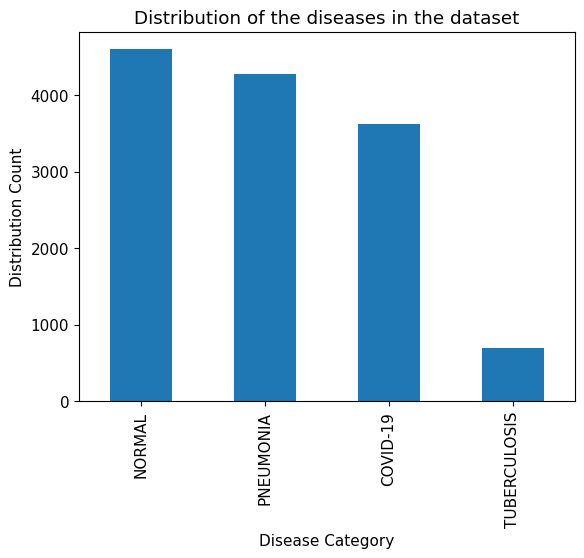

In [37]:
fig = plt.figure()
df_2['label'].value_counts().plot(kind = "bar")
plt.xlabel("Disease Category")
plt.ylabel("Distribution Count")
plt.title("Distribution of the diseases in the dataset")
plt.show()

## Splitting the data - use of stratified sampling (for imbalanced data) 

In [38]:
train_val, test = train_test_split(df_2, test_size=0.1, stratify=df_2['label'], random_state=42)
train, val_df = train_test_split(train_val, test_size=0.1, stratify=train_val['label'], random_state=42)
print("The respective sizes of train, test and validation sets are:")
print("Train set:", len(train))
print("Test set:", len(test))
print("Validation set:", len(val_df))

The respective sizes of train, test and validation sets are:
Train set: 10682
Test set: 1319
Validation set: 1187


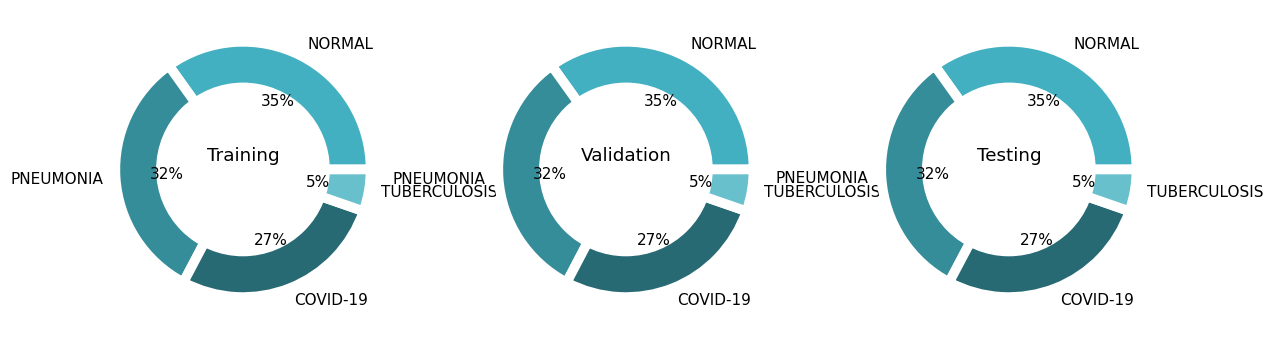

In [39]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 3, 1)
plt.pie(list(train.label.value_counts()),
        labels=list(train.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 

fig.add_subplot(1, 3, 2)
plt.pie(list(val_df.label.value_counts()),
        labels=list(val_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

fig.add_subplot(1, 3, 3)
plt.pie(list(test.label.value_counts()),
        labels=list(test.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Testing', x=0.5, y=0.5) 
plt.show()


# Preprocess the images with generators

In [40]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.64, 1.37),
    vertical_flip=True,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [41]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    directory = None,
    x_col="image",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256)
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image",
    y_col="label",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(256,256)
)

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=None,
    x_col="image",
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(256,256)
)


Found 10682 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.
Found 1319 validated image filenames.


> Models to use and compare:
1. ResNet50
2. Vgg16
3. InceptionV3
4. Vgg19
5. DenseNet121

In [42]:
#1.ResNet-50
base_resnet = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))
for layer in base_resnet.layers[:-10]:
    layers.trainable=False
hm = base_resnet.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)
resnet_model = Model(inputs=base_resnet.input, outputs = hm)

In [43]:
#2.VGG16
base_vgg16 = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))
for layer in base_vgg16.layers[:-10]:
    layers.trainable=False
hvgg16 = base_vgg16.output
hvgg16 = AveragePooling2D(pool_size=(4,4))(hvgg16)
hvgg16 = Flatten(name = 'flatten')(hvgg16)
hvgg16 = Dense(256, activation = 'relu')(hvgg16)
hvgg16 = Dropout(0.3)(hvgg16)
hvgg16 = Dense(128, activation = 'relu')(hvgg16)
hvgg16 = Dropout(0.2)(hvgg16)
hvgg16 = Dense(4,activation = 'softmax')(hvgg16)
vgg16_model = Model(inputs=base_vgg16.input, outputs = hvgg16)

In [44]:
#3.VGG19
base_vgg19 = VGG19(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))
for layer in base_vgg19.layers[:-10]:
    layers.trainable=False
hvgg19 = base_vgg19.output
hvgg19 = AveragePooling2D(pool_size=(4,4))(hvgg19)
hvgg19 = Flatten(name = 'flatten')(hvgg19)
hvgg19 = Dense(256, activation = 'relu')(hvgg19)
hvgg19 = Dropout(0.3)(hvgg19)
hvgg19 = Dense(128, activation = 'relu')(hvgg19)
hvgg19 = Dropout(0.2)(hvgg19)
hvgg19 = Dense(4,activation = 'softmax')(hvgg19)
vgg19_model = Model(inputs=base_vgg19.input, outputs = hvgg19)

In [45]:
#4.InceptionV3
base_inception = InceptionV3(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))
for layer in base_inception.layers[:-10]:
    layers.trainable=False
inception = base_inception.output
inception = AveragePooling2D(pool_size=(4,4))(inception)
inception = Flatten(name = 'flatten')(inception)
inception = Dense(256, activation = 'relu')(inception)
inception = Dropout(0.3)(inception)
inception = Dense(128, activation = 'relu')(inception)
inception = Dropout(0.2)(inception)
inception = Dense(4,activation = 'softmax')(inception)
inception_model = Model(inputs=base_inception.input, outputs = inception)

In [46]:
base_densenet = DenseNet121(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))
for layer in base_densenet.layers[:-10]:
    layers.trainable=False
densenet = base_densenet.output
densenet = AveragePooling2D(pool_size=(4,4))(densenet)
densenet = Flatten(name = 'flatten')(densenet)
densenet = Dense(256, activation = 'relu')(densenet)
densenet = Dropout(0.3)(densenet)
densenet = Dense(128, activation = 'relu')(densenet)
densenet = Dropout(0.2)(densenet)
densenet = Dense(4,activation = 'softmax')(densenet)
densenet_model = Model(inputs=base_densenet.input, outputs = densenet)

> Compile the models

In [47]:
from tensorflow.keras import optimizers
resnet_model.compile(loss='categorical_crossentropy',optimizer = 'sgd',
                  metrics=['accuracy'])
inception_model.compile(loss='categorical_crossentropy',optimizer = 'sgd',
                  metrics=['accuracy'])
densenet_model.compile(loss='categorical_crossentropy',optimizer = 'sgd',
                  metrics=['accuracy'])
vgg16_model.compile(loss='categorical_crossentropy',optimizer = 'sgd',
                  metrics=['accuracy'])

vgg19_model.compile(loss='categorical_crossentropy',optimizer = 'sgd',
                  metrics=['accuracy'])

In [48]:
batch_size = 32
epochs = 5
history = resnet_model.fit(
    train_gen,
    steps_per_epoch=train_gen.n//batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
333/333 [==============================] - 385s 1s/step - loss: 0.4437 - accuracy: 0.8306 - val_loss: 2.5405 - val_accuracy: 0.2745
Epoch 2/5
333/333 [==============================] - 267s 802ms/step - loss: 0.2506 - accuracy: 0.9084 - val_loss: 1.7274 - val_accuracy: 0.3454
Epoch 3/5
333/333 [==============================] - 283s 850ms/step - loss: 0.1871 - accuracy: 0.9300 - val_loss: 0.5721 - val_accuracy: 0.8024
Epoch 4/5
333/333 [==============================] - 265s 797ms/step - loss: 0.1588 - accuracy: 0.9411 - val_loss: 3.0913 - val_accuracy: 0.4561
Epoch 5/5
333/333 [==============================] - 284s 852ms/step - loss: 0.1394 - accuracy: 0.9505 - val_loss: 0.6660 - val_accuracy: 0.7652


In [49]:
history2 = vgg16_model.fit(
    train_gen,
    steps_per_epoch=train_gen.n//batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
333/333 [==============================] - 284s 828ms/step - loss: 0.8212 - accuracy: 0.6629 - val_loss: 0.5397 - val_accuracy: 0.7711
Epoch 2/5
333/333 [==============================] - 287s 861ms/step - loss: 0.5114 - accuracy: 0.8028 - val_loss: 0.4370 - val_accuracy: 0.8285
Epoch 3/5
333/333 [==============================] - 288s 865ms/step - loss: 0.4047 - accuracy: 0.8417 - val_loss: 0.2978 - val_accuracy: 0.9122
Epoch 4/5
333/333 [==============================] - 273s 820ms/step - loss: 0.3660 - accuracy: 0.8564 - val_loss: 0.3218 - val_accuracy: 0.8716
Epoch 5/5
333/333 [==============================] - 273s 818ms/step - loss: 0.3451 - accuracy: 0.8686 - val_loss: 0.2935 - val_accuracy: 0.8851


In [50]:
history3 = vgg19_model.fit(
    train_gen,
    steps_per_epoch=train_gen.n//batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
333/333 [==============================] - 302s 899ms/step - loss: 0.7997 - accuracy: 0.6745 - val_loss: 0.4500 - val_accuracy: 0.8387
Epoch 2/5
333/333 [==============================] - 293s 881ms/step - loss: 0.5012 - accuracy: 0.8077 - val_loss: 0.4672 - val_accuracy: 0.8328
Epoch 3/5
333/333 [==============================] - 290s 872ms/step - loss: 0.4688 - accuracy: 0.8184 - val_loss: 0.4336 - val_accuracy: 0.7981
Epoch 4/5
333/333 [==============================] - 274s 823ms/step - loss: 0.3640 - accuracy: 0.8604 - val_loss: 0.2526 - val_accuracy: 0.9079
Epoch 5/5
333/333 [==============================] - 291s 875ms/step - loss: 0.3598 - accuracy: 0.8615 - val_loss: 0.2119 - val_accuracy: 0.9257


In [51]:
history4 = inception_model.fit(
    train_gen,
    steps_per_epoch=train_gen.n//batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
333/333 [==============================] - 306s 851ms/step - loss: 0.5272 - accuracy: 0.7973 - val_loss: 0.2710 - val_accuracy: 0.8953
Epoch 2/5
333/333 [==============================] - 259s 779ms/step - loss: 0.2906 - accuracy: 0.8986 - val_loss: 0.2757 - val_accuracy: 0.8961
Epoch 3/5
333/333 [==============================] - 259s 777ms/step - loss: 0.2115 - accuracy: 0.9249 - val_loss: 0.1827 - val_accuracy: 0.9341
Epoch 4/5
333/333 [==============================] - 260s 780ms/step - loss: 0.1783 - accuracy: 0.9365 - val_loss: 0.1198 - val_accuracy: 0.9535
Epoch 5/5
333/333 [==============================] - 276s 829ms/step - loss: 0.1591 - accuracy: 0.9428 - val_loss: 1.0243 - val_accuracy: 0.6909


In [52]:
history5 = densenet_model.fit(
    train_gen,
    steps_per_epoch=train_gen.n//batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
333/333 [==============================] - 329s 879ms/step - loss: 0.4868 - accuracy: 0.8137 - val_loss: 0.4651 - val_accuracy: 0.8066
Epoch 2/5
333/333 [==============================] - 268s 804ms/step - loss: 0.2668 - accuracy: 0.9010 - val_loss: 0.2306 - val_accuracy: 0.9096
Epoch 3/5
333/333 [==============================] - 286s 859ms/step - loss: 0.2022 - accuracy: 0.9246 - val_loss: 0.4236 - val_accuracy: 0.8294
Epoch 4/5
333/333 [==============================] - 268s 803ms/step - loss: 0.1726 - accuracy: 0.9384 - val_loss: 0.2983 - val_accuracy: 0.8742
Epoch 5/5
333/333 [==============================] - 269s 807ms/step - loss: 0.1480 - accuracy: 0.9482 - val_loss: 0.2014 - val_accuracy: 0.9147
